In [ ]:
#AJUSTANDO HUBBLE# (Om0 fijado)
##################

import numpy as np
import matplotlib.pyplot as plt
import emcee
from astropy.cosmology import FlatLambdaCDM
import corner
import scipy.optimize as op #EMCEE
from astropy.table import Table
import numpy as np
import math
import scipy.integrate as integrate

np.random.seed(123)

# Choose the "true" parameters.
c_light=299792.458
om=0.27
MJ, H0, sigma_int = -18.5, 73., 0.20 

# Generate some synthetic data from the model.
#iz, imb, iez, iemb  = ([] for i in range(4))
#sim = Table.read('Hubble-allband.txt', format='ascii')
#for i in range(len(sim)):
#    imb.append(sim[i][0])
#    iz.append(sim[i][1])    
#    iez.append(0.01)
#    iemb.append(0.01)
#imb =np.array(imb )
#iz  =np.array(iz  )
#iez =np.array(iez )
#iemb=np.array(iemb)

iz=np.array([0.0334,0.0094,0.0284,0.0065,0.0192,0.0135,0.0151,0.0052,0.029,0.0219,0.0273,0.0261,0.0167,0.0379,0.0109,0.0328,0.034,0.0141,0.0057,0.0592,0.025,0.034,0.0158,0.0459,0.0086,0.0284,0.0177,0.0067,0.0371,0.0235,0.0126,0.0151,0.0317,0.0208,0.0389,0.0193,0.0213,0.0309,0.0055,0.0062,0.0455,0.022,0.0226,0.045,0.0157,0.0149,0.0211,0.0112])
imb=np.array([17.12683,14.31732,16.81627,13.05293,16.04434,15.35834,15.47661,12.68107,16.82994,16.41775,16.76588,16.67282,15.70141,17.28193,14.78798,17.18085,17.11246,15.71992,13.48464,18.40173,16.31387,17.26866,15.51119,17.83404,14.7345,17.15616,15.80136,13.75173,17.5826,16.41359,15.27002,15.61415,17.23851,16.19666,17.53262,15.91536,16.42056,16.9714,13.45125,13.77067,17.63573,16.42845,16.09664,17.60869,15.38943,15.50568,16.1714,15.14125])
iez=np.array([0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001])
iemb=np.array([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01])

#grafica 1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.errorbar(iz, imb, yerr=iemb, fmt=".k", capsize=0, label='Datos inicial')
z=np.array(range(100))/1000.
cosmo = FlatLambdaCDM(H0, om)
mbcosmo=cosmo.distmod(z).value+MJ
ax1.plot(z, mbcosmo, "k", alpha=0.3, lw=3, label="Inicial")
ax1.axis(xmin=0.,xmax=0.065)
#ax1.axis(ymin=30.5,ymax=37.5)
ax1.set_xlabel('Desplazamiento al rojo',fontsize=10)
ax1.set_ylabel('Jmax [Mag]',fontsize=10)
ax1.legend(fontsize=14)

######## Maximum likelihood estimation

def e_z(z,om):
    ol=1-(om)
    ok=0
    return (1.0/math.sqrt((om)*((1+z)**3)+ (ok)*((1+z)**2) + ol))

def r_com(z,om):
    return integrate.quad(e_z,0.,z,args=((om)))[0] 

def H0DL_cosmo_func(z,om):
    om=abs(om)
    H0DL_cosmo_final=[] 
    for i in range(len(z)):
        H0DL_cosmo_final.append( c_light*((1+z[i])/H0)*r_com(z[i],om)  )
    return H0DL_cosmo_final

def log_likelihood(p, iz,imb,iez,iemb):
    MJ, H0, sigma_int = p
    model = MJ + 5 *np.log10( H0DL_cosmo_func(iz,om) ) +25
    zerr = np.sqrt(np.array(iez)**2.0+(150/c_light)**2.0)
    sig_z=np.array(zerr)*(5*(1+np.array(iz))*1.0/(np.array(iz)*(1+np.array(iz)*1.0/2)*np.log(10)))
    sigma_total =iemb**2 + sig_z**2 + sigma_int**2
    inv_sigma_total = 1.0/sigma_total
    return -0.5*(np.sum((imb-model)**2*inv_sigma_total-np.log(inv_sigma_total)))

from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([MJ, H0, sigma_int]) + 0.1 * np.random.randn(3)
result = minimize(nll, initial, args=(iz,imb,iez,iemb))
MJ_ml, H0_ml, sigma_ml = result.x

print("Maximum likelihood estimates:")
print("MJ = {0:.3f}".format(MJ_ml))
print("H0 = {0:.3f}".format(H0_ml))
print("sigma = {0:.3f}".format(sigma_ml))

#grafica 2
cosmo = FlatLambdaCDM(H0_ml, om)
mucosmo=cosmo.distmod(z).value
ax2.plot(z, mucosmo + MJ_ml, "k", alpha=0.3, lw=3, label="ML")
ax2.errorbar(iz, imb, yerr=iemb, fmt=".r", capsize=0, label='Datos ML')
ax2.axis(xmin=0.,xmax=0.065)
#ax2.axis(ymin=30.5,ymax=37.5)
ax2.set_xlabel('Desplazamiento al rojo',fontsize=10)
ax2.set_ylabel('Jmax [Mag]',fontsize=10)
ax2.legend(fontsize=14)

######## Marginalization & uncertainty estimation ########
print('-------Marginalization & uncertainty estimation---------')

def log_prior(p):
    MJ, H0, sigma_int = p
    if (-22.<MJ<-15.) and (60.<H0<80.) and (0.0<sigma_int<0.5): 
        return 0.0
    return -np.inf

def log_probability(p, iz,imb,iez,iemb):
    lp = log_prior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(p, iz,imb,iez,iemb)

import emcee
ndim , nwalkers = 3 , 50
pos=[np.array([MJ, H0,  sigma_int])+1.e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(iz,imb,iez,iemb))

#run MCMC
pos, prob, state  = sampler.run_mcmc(pos, 500) #flatten the chain and remove the 150 first steps
nburns=50
samples=sampler.chain[:, nburns:, :].reshape((-1,ndim))
MJ_mcmc, H0_mcmc, sigma_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0))) 
print(MJ_mcmc, H0_mcmc, sigma_mcmc)
print('MCMC')
print('MJ =',MJ_mcmc[0],'H0 =', H0_mcmc[0],'sigma =', sigma_mcmc[0])

#grafica 3
cosmo = FlatLambdaCDM(H0_mcmc[0], om)
mucosmo=cosmo.distmod(z).value
ax3.plot(z, mucosmo + MJ_mcmc[0], "k", alpha=0.3, lw=3, label="MCMC")
ax3.errorbar(iz, imb, yerr=iemb, fmt=".b", capsize=0, label='Datos MCMC')
ax3.axis(xmin=0.,xmax=0.065)
#ax3.axis(ymin=30.5,ymax=37.5)
ax3.set_xlabel('Desplazamiento al rojo',fontsize=10)
ax3.set_ylabel('Jmax [Mag]',fontsize=10)
ax3.legend(fontsize=14)

fig.tight_layout()
fig.savefig('Hubble.Comp.jpg', dpi=500)
plt.show()
plt.close(fig)

#GRAFICAS ERRORES
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0_mcmc[0], om)

fig, ax = plt.subplots(3,1,figsize=(10,10), sharex=True)
plt.sca(ax[0])
plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)
plt.ylabel('MJ')
plt.sca(ax[1])
plt.plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)
plt.ylabel('H0')
plt.sca(ax[2])
plt.plot(sampler.chain[:,:,2].T, '-', color='k', alpha=0.3)
plt.ylabel('sigma_int')
plt.xlabel('samples')
plt.savefig('EMCEE_cosmo.png')
plt.show()
plt.close("all")

fig = corner.corner(samples, labels=["$MJ$", "$H0$", r"$sigma_{int} $"],truths=result["x"],
                    label_kwargs={"fontsize": 15},quantiles=[0.16, 0.5, 0.84],show_titles=True, 
                    title_kwargs={"fontsize": 15,"fontweight":'bold'})
plt.savefig('EMCEE_results.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close("all")

---------------------------
allband
Maximum likelihood estimates:
HM = -27.836
sigma = 0.154
H0= 72.99999999999996 cuando MJ= -18.5


/home/antonio98y/.local/lib/python3.8/site-packages/astropy/cosmology/core.py:1449: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/antonio98y/.local/lib/python3.8/site-packages/astropy/cosmology/core.py:1449: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


-------Marginalization & uncertainty estimation---------
(-27.836312036421347, 0.02492178292472147) (0.15977055090698325, 0.02240225020032824)
MCMC
H0 = 73.6652059353344 Cuando MJ = -18.5 ; sigma = 0.15977055090698325


/home/antonio98y/.local/lib/python3.8/site-packages/astropy/cosmology/core.py:1449: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


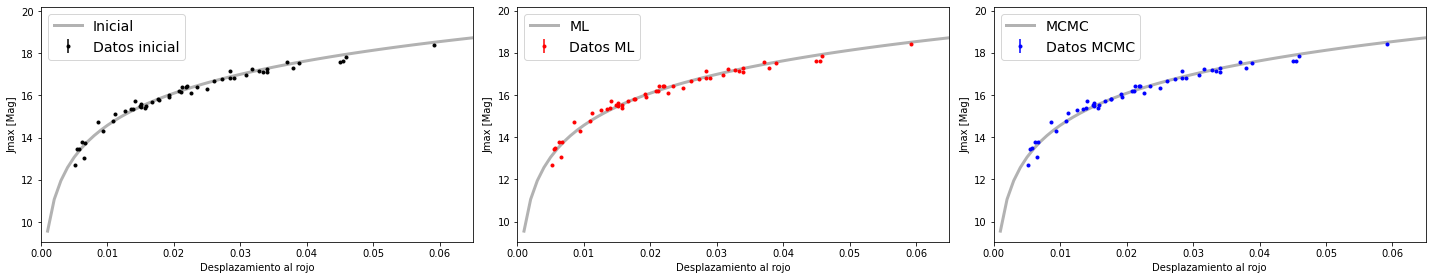

---------------------------
grJH
Maximum likelihood estimates:
HM = -27.850
sigma = 0.162
H0= 72.99999999999996 cuando MJ= -18.5
-------Marginalization & uncertainty estimation---------


/home/antonio98y/.local/lib/python3.8/site-packages/astropy/cosmology/core.py:1449: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/antonio98y/.local/lib/python3.8/site-packages/astropy/cosmology/core.py:1449: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


(-27.849483949879577, 0.026410890054648917) (0.16769364845630763, 0.023197084802800888)
MCMC
H0 = 74.1134089955703 Cuando MJ = -18.5 ; sigma = 0.16769364845630763


/home/antonio98y/.local/lib/python3.8/site-packages/astropy/cosmology/core.py:1449: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


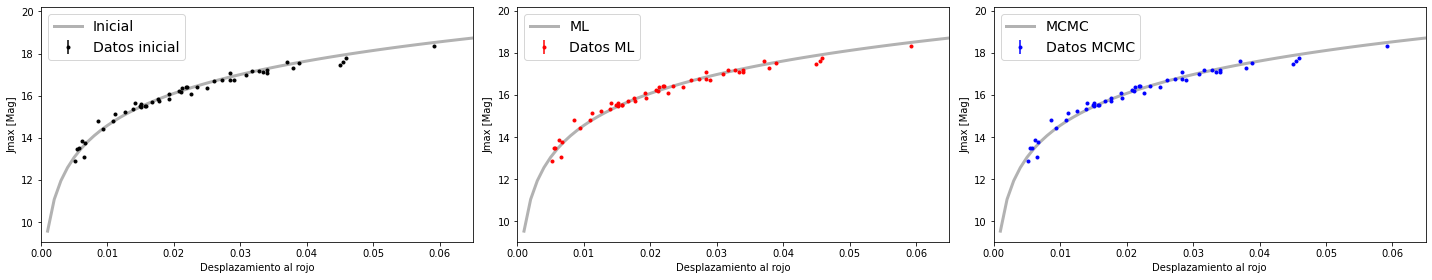

---------------------------
flows
Maximum likelihood estimates:
HM = -27.857
sigma = 0.158
H0= 72.99999999999996 cuando MJ= -18.5
-------Marginalization & uncertainty estimation---------


/home/antonio98y/.local/lib/python3.8/site-packages/astropy/cosmology/core.py:1449: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/antonio98y/.local/lib/python3.8/site-packages/astropy/cosmology/core.py:1449: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


(-27.856162685066764, 0.02779368882034916) (0.16403846653516074, 0.024416235572154305)
MCMC
H0 = 74.34170838132174 Cuando MJ = -18.5 ; sigma = 0.16403846653516074


/home/antonio98y/.local/lib/python3.8/site-packages/astropy/cosmology/core.py:1449: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


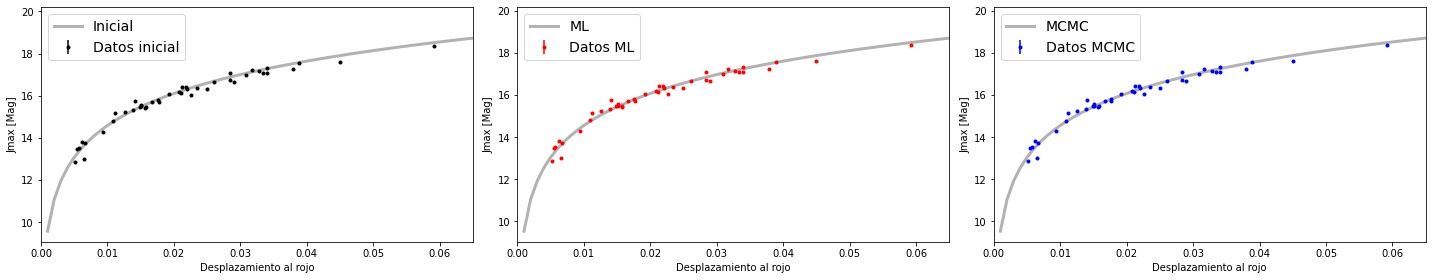

FIN


In [29]:
#AJUSTANDO HUBBLE# (Om0 fijado y H0(MJ))
##################

import numpy as np
import matplotlib.pyplot as plt
import emcee
from astropy.cosmology import FlatLambdaCDM
import corner
import scipy.optimize as op #EMCEE
from astropy.table import Table
import numpy as np
import math
import scipy.integrate as integrate

np.random.seed(123)

#b="resultados/"+"Hubble-allband.txt" 
hubble=['allband','grJH','flows']

for k9 in range(len(hubble)):   
    b="resultados/Hubble-"+hubble[k9]+".txt"
    print('---------------------------')
    print(hubble[k9])
    
    # Generate some synthetic data from the model.
    iz, imb, iez, iemb  = ([] for i in range(4))
    sim = Table.read(b, format='ascii')
    for i in range(len(sim)):
        imb.append(sim[i][0])
        iz.append(sim[i][1])    
        iez.append(0.0001)
        iemb.append(0.01)
    imb =np.array(imb )
    iz  =np.array(iz  )
    iez =np.array(iez )
    iemb=np.array(iemb)

    #iz=np.array([0.0334,0.0094,0.0284,0.0065,0.0192,0.0135,0.0151,0.0052,0.029,0.0219,0.0273,0.0261,0.0167,0.0379,0.0109,0.0328,0.034,0.0141,0.0057,0.0592,0.025,0.034,0.0158,0.0459,0.0086,0.0284,0.0177,0.0067,0.0371,0.0235,0.0126,0.0151,0.0317,0.0208,0.0389,0.0193,0.0213,0.0309,0.0055,0.0062,0.0455,0.022,0.0226,0.045,0.0157,0.0149,0.0211,0.0112])
    #imb=np.array([17.12683,14.31732,16.81627,13.05293,16.04434,15.35834,15.47661,12.68107,16.82994,16.41775,16.76588,16.67282,15.70141,17.28193,14.78798,17.18085,17.11246,15.71992,13.48464,18.40173,16.31387,17.26866,15.51119,17.83404,14.7345,17.15616,15.80136,13.75173,17.5826,16.41359,15.27002,15.61415,17.23851,16.19666,17.53262,15.91536,16.42056,16.9714,13.45125,13.77067,17.63573,16.42845,16.09664,17.60869,15.38943,15.50568,16.1714,15.14125])
    #iez=np.array([0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001])
    #iemb=np.array([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01])

    # Choose the "true" parameters.
    c_light=299792.458
    #om=0.27
    om=0.315
    MJ, H0, sigma_int = -18.5, 73., 0.20
    HM=MJ-5.*np.log10(H0)

    #grafica 1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
    ax1.errorbar(iz, imb, yerr=iemb, fmt=".k", capsize=0, label='Datos inicial')
    z=np.array(range(100))/1000.
    cosmo = FlatLambdaCDM(H0, om)
    mbcosmo=cosmo.distmod(z).value+MJ
    ax1.plot(z, mbcosmo, "k", alpha=0.3, lw=3, label="Inicial")
    ax1.axis(xmin=0.,xmax=0.065)
    #ax1.axis(ymin=30.5,ymax=37.5)
    ax1.set_xlabel('Desplazamiento al rojo',fontsize=10)
    ax1.set_ylabel('Jmax [Mag]',fontsize=10)
    ax1.legend(fontsize=14)

    ######## Maximum likelihood estimation

    def e_z(z,om):
        ol=1-(om)
        ok=0
        return (1.0/math.sqrt((om)*((1+z)**3)+ (ok)*((1+z)**2) + ol))

    def r_com(z,om):
        return integrate.quad(e_z,0.,z,args=((om)))[0] 

    def DL_cosmo_func(z,om):
        om=abs(om)
        DL_cosmo_final=[] 
        for i in range(len(z)):
            DL_cosmo_final.append( c_light*((1+z[i]))*r_com(z[i],om)  )
        return DL_cosmo_final

    def log_likelihood(p, iz,imb,iez,iemb):
        HM, sigma_int = p
        model = HM + 5 *np.log10( DL_cosmo_func(iz,om) ) +25
        zerr = np.sqrt(np.array(iez)**2.0+(150/c_light)**2.0)
        sig_z=np.array(zerr)*(5*(1+np.array(iz))*1.0/(np.array(iz)*(1+np.array(iz)*1.0/2)*np.log(10)))
        sigma_total =iemb**2 + sig_z**2 + sigma_int**2
        inv_sigma_total = 1.0/sigma_total
        return -0.5*(np.sum((imb-model)**2*inv_sigma_total-np.log(inv_sigma_total)))

    def H0_HM(HM,MJ):
        return 10.**((MJ-HM)/5.)

    from scipy.optimize import minimize

    np.random.seed(42)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([HM, sigma_int]) + 0.1 * np.random.randn(2)
    result = minimize(nll, initial, args=(iz,imb,iez,iemb))
    HM_ml, sigma_ml = result.x

    print("Maximum likelihood estimates:")
    print("HM = {0:.3f}".format(HM_ml))
    print("sigma = {0:.3f}".format(sigma_ml))
    print('H0=',H0_HM(HM,MJ),'cuando MJ=',MJ)

    #grafica 2
    cosmo = FlatLambdaCDM(H0_HM(HM_ml,MJ), om)
    mucosmo=cosmo.distmod(z).value
    ax2.plot(z, mucosmo + MJ, "k", alpha=0.3, lw=3, label="ML")
    ax2.errorbar(iz, imb, yerr=iemb, fmt=".r", capsize=0, label='Datos ML')
    ax2.axis(xmin=0.,xmax=0.065)
    #ax2.axis(ymin=30.5,ymax=37.5)
    ax2.set_xlabel('Desplazamiento al rojo',fontsize=10)
    ax2.set_ylabel('Jmax [Mag]',fontsize=10)
    ax2.legend(fontsize=14)

    ######## Marginalization & uncertainty estimation ########
    print('-------Marginalization & uncertainty estimation---------')

    def log_prior(p):
        MH, sigma_int = p
        #if (-40.<HM<-10.) and (0.0<sigma_int<0.5):      
        if (-30.<HM<-26.) and (0.0<sigma_int<0.4):  ##################################
            return 0.0
        return -np.inf

    def log_probability(p, iz,imb,iez,iemb):
        lp = log_prior(p)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(p, iz,imb,iez,iemb)

    import emcee
    ndim , nwalkers = 2 , 200
    pos=[np.array([HM, sigma_int])+1.e-4*np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(iz,imb,iez,iemb))

    #run MCMC
    pos, prob, state  = sampler.run_mcmc(pos, 2000) #flatten the chain and remove the 150 first steps
    nburns=50
    samples=sampler.chain[:, nburns:, :].reshape((-1,ndim))
    HM_mcmc,  sigma_mcmc = map(lambda v: (v[1], v[2]-v[1]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))  #TENGO DUDAS CON ESTA LÍNEA
    print(HM_mcmc, sigma_mcmc)
    print('MCMC')
    print('H0 =', H0_HM(HM_mcmc[0],MJ),'Cuando MJ =',MJ, '; sigma =', sigma_mcmc[0])

    #grafica 3
    cosmo = FlatLambdaCDM(H0_HM(HM_mcmc[0],MJ), om)
    mucosmo=cosmo.distmod(z).value
    ax3.plot(z, mucosmo + MJ, "k", alpha=0.3, lw=3, label="MCMC")
    ax3.errorbar(iz, imb, yerr=iemb, fmt=".b", capsize=0, label='Datos MCMC')
    ax3.axis(xmin=0.,xmax=0.065)
    #ax3.axis(ymin=30.5,ymax=37.5)
    ax3.set_xlabel('Desplazamiento al rojo',fontsize=10)
    ax3.set_ylabel('Jmax [Mag]',fontsize=10)
    ax3.legend(fontsize=14)

    fig.tight_layout()
    fig.savefig('resultados/Hubble.Comp-'+hubble[k9]+'.jpg', dpi=500)
    plt.show()
    plt.close(fig)

    #GRAFICAS ERRORES
    import matplotlib.pyplot as plt
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0_HM(HM_mcmc[0],MJ), om)

    fig, ax = plt.subplots(2,1,figsize=(10,10), sharex=True)
    plt.sca(ax[0])
    plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)
    plt.ylabel('HM')
    plt.sca(ax[1])
    plt.plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)
    plt.ylabel('sigma_int',fontsize=13)
    plt.xlabel('samples',fontsize=13)
    plt.savefig('resultados/EMCEE_cosmo-'+hubble[k9]+'.png')
    #plt.show()
    plt.close("all")

    fig = corner.corner(samples, labels=["$HM$", r"$sigma_{int} $"],truths=result["x"],
                        label_kwargs={"fontsize": 15},quantiles=[0.16, 0.5, 0.84],show_titles=True, 
                        title_kwargs={"fontsize": 15,"fontweight":'bold'})
    plt.savefig('resultados/EMCEE_results-'+hubble[k9]+'.png',dpi=300,bbox_inches='tight')
    #plt.show()
    plt.close("all")
print('FIN')

HO: 74.47319739059888 ; H0err: 1.0288852448351762


/home/antonio98y/.local/lib/python3.8/site-packages/astropy/cosmology/core.py:1449: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


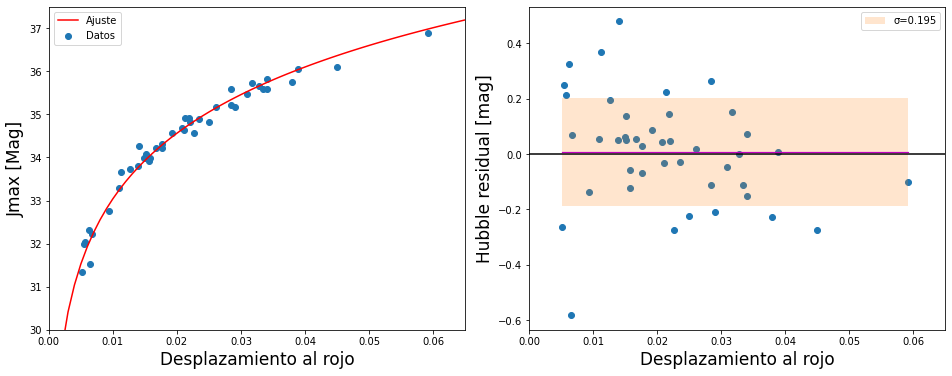

FIN


In [36]:
#Gráficas de Hubble y determinación de H_0

import numpy as np
import math
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM

#Valores HM 
k9=2
HM=-27.86
HMerr1=0.03
#MJ Y Om0 fijo
M=-18.5
Merr=0.0
Om0=0.315

#Calculo de H0
def H0_HM(HM,MJ):
    return 10.**((MJ-HM)/5.)
def H0err(HM,HMerr,MJ,MJerr):
    err1=(np.log(10.)/5.)*H0_HM(HM,MJ)
    err=err1**2*(HMerr**2+MJerr**2)
    return math.sqrt(err)

H0=H0_HM(HM,M)

print('HO:',H0,'; H0err:', H0err(HM,HMerr1,M,Merr)) 

#Determina la dispersion de los datos       
def dispersion(i,dia,jm1,jm12):
    if i==0: #dispersion general
        media=np.nanmean(jm1)
        disp=np.nanstd(jm1)
        jm12.append([media,media])
        jm12.append(media-disp)
        jm12.append(media+disp)
        jm12.append(round(disp,3))
    elif i==2: #dispersion -10 y 20 dias
        jm13=[]
        con1=0
        for day in dia:
            if day>=-10.0 and day<=20.0:
                jm13.append(jm1[con1])
            con1=con1+1
        media=np.nanmean(jm13)
        disp=np.nanstd(jm13)
        jm12.append([media,media])
        jm12.append(media-disp)
        jm12.append(media+disp)
        jm12.append(round(disp,3))
    elif i==3: #dispersion -5 y 5 dias
        jm13=[]
        con1=0
        for day in dia:
            if day>=-5.0 and day<=10.0:
                jm13.append(jm1[con1])
            con1=con1+1
        media=np.nanmean(jm13)
        disp=np.nanstd(jm13)
        jm12.append([media,media])
        jm12.append(media-disp)
        jm12.append(media+disp)
        jm12.append(round(disp,3))
    elif i==1: #Buscamos máximo y mínimo valor en t  
        jm12.append(min(jm1))
        jm12.append(max(jm1)) 
  
    
hubble=['allband','grJH','flows']  
b="resultados/Hubble-"+hubble[k9]+".txt"

#Lectura de los datos de los txt
sim = Table.read(b, format='ascii')

#Variables necesarias para el Diagrama de Hubble
sz, sz1, musn, musn1, musn12, mucosmo  = ([] for i in range(6))
z=np.array(range(100))/1000.
cosmo = FlatLambdaCDM(H0, Om0)
mucosmo=cosmo.distmod(z)

for i in range(len(sim)):
    musn.append(sim[i][0]-M)
    sz.append(sim[i][1])
    #musn-cosmo.distmod(sz).value
    musn1.append((sim[i][0]-M)-(cosmo.distmod(sim[i][1]).value))


#Creación de 2 gráficas juntas con subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.33,5.33))

ax1.plot(z, mucosmo,'r',label='Ajuste')
ax1.scatter(sz, musn,label='Datos')
ax1.legend(loc='best')
ax1.set_xlabel('Desplazamiento al rojo',fontsize=17)
ax1.set_ylabel('Jmax [Mag]',fontsize=17)

ax2.plot([0,0.1],[0.0,0.0],'k')
ax2.scatter(sz,musn1)
#ax2.axis(ymin=-0.5,ymax=0.5)
dispersion(1,sz,sz,sz1)
dispersion(0,0,musn1,musn12)
ax2.plot(sz1,musn12[0],'m',linewidth=1.2)
ax2.fill_between(sz1,musn12[1],musn12[2],alpha=0.2,label='σ='+str(musn12[3]))
ax2.legend(loc='best')
ax2.set_ylabel('Hubble residual [mag]',fontsize=17)
ax2.set_xlabel('Desplazamiento al rojo',fontsize=17)

fig.tight_layout()

ax1.set_xlim([0, 0.065])
ax2.set_xlim([0, 0.065])
ax1.set_ylim([30, 37.5])

            
fig.savefig(b +'.jpeg', dpi=500)
plt.show()
plt.close(fig)

print('FIN')